# A Cloropleth Map of NY State Oil Spills by County From Jan. 2023 to Oct. 2023

### By Kaiju Morquecho
Created on 11/12/2025

[My Github](https://github.com/kaimorquecho/eds220-hwk3.git)

### Complete workflow to create map:

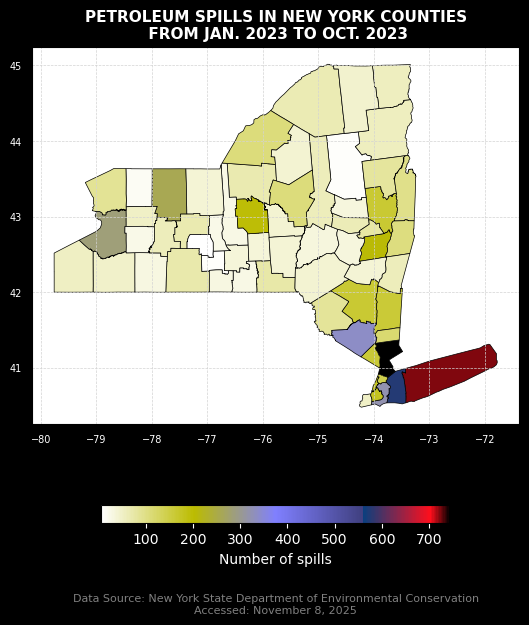

In [1]:
# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

# Import data
# Set the path for project's library 
os.environ['PROJ_LIB'] = '/opt/anaconda3/share/proj'

# Construct file path for spills dataset using 'os' package
fp = os.path.join('data','Spill_Incidents_20251107.csv')
spills = pd.read_csv(fp)

# Construct file path for counties dataset using 'os' package
fp = os.path.join('data','tl_2023_us_county','tl_2023_us_county.shp')
counties = gpd.read_file(fp)


# Simplify column names in spills DataFrame
spills.columns = spills.columns.str.lower().str.replace(' ','_') 

# Update 'spill_date' to a datetime object 
spills['spill_date'] = pd.to_datetime(spills['spill_date'])

# Update index to column 'spill_date' to subset using the index
spills = spills.set_index('spill_date')

# NAs in the spill_date index prevent the index from being sorted, drop NAs and sort
spills = spills[spills.index.notna()].sort_index()

# Use label indexing to subset to petroleum spills from 01-1-2023 - 10-31-2023
petr_23 = spills.loc[(spills.index >= '2023-01-01') & 
                     (spills.index <= '2023-10-31') & (spills['material_family'] == 'Petroleum')]


# Create new dataframe named spills_per_county with the number of petroleum spills per county from January to October 2023 
spills_per_county = (petr_23.reset_index()
                            .groupby('county',as_index = False)['spill_date']
                            .count().rename(columns={'spill_date':'n_spills'}))

# Update column names in counties DataFrame to lowercase
counties.columns = counties.columns.str.lower()

# Select NY counties using 'statefp' column, NY is 'statefp'=36
ny_counties = counties[counties['statefp'] == '36']

# Replace 'St Lawrence' county value with 'St. Lawrence' in spills_per_county DataFrame
spills_per_county['county'] = spills_per_county['county'].replace('St Lawrence', 'St. Lawrence')

# DataFrames have different column names, rename ny_counties column 'name' to 'county'
ny_counties = ny_counties.rename(columns = {'name':'county'})

# Inner join ny_counties and spills_per_county DataFrames on 'county' column
ny_counties = pd.merge(ny_counties, spills_per_county, on = 'county', how = 'inner')

# Add one spill to Niagara county to make up for Tuscarora Indian Reservation not being in the DataFrame anymore
ny_counties.loc[ny_counties.county=='Niagara','n_spills'] += 1


# Create cloropleth map of petroleum spills
fig, ax = plt.subplots(figsize = (9,7))

fig.patch.set_facecolor("black")  # Change background color


# Leave axis on 
ax.axis('on')

# Create cloropleth
ny_counties.plot(ax = ax,
                 column = 'n_spills',
                 cmap = 'gist_stern_r',
                 legend=True,
                 edgecolor = 'black',
                 linewidth=0.5,
                 legend_kwds={
                    "shrink": 0.5,
                    "label": "Number of spills",
                    "orientation": "horizontal",
                    "pad":0.15
                 }
                )

# Add title and annotation that includes data citation and date of access
ax.set_title('PETROLEUM SPILLS IN NEW YORK COUNTIES\n FROM JAN. 2023 TO OCT. 2023', 
             weight='bold', 
             fontsize=11,
             color='white')

ax.annotate('Data Source: New York State Department of Environmental Conservation\nAccessed: November 8, 2025',
 xy=(0.5, -0.5),
    xycoords='axes fraction',
    ha='center', 
    fontsize=8,
    color='gray'
)

# Add a grid and make aesthethic adjustments
ax.grid(True, which='major',
        color='lightgray',
        linestyle='--',
        linewidth=0.5)

# Update size and color of plot's ticks 
ax.tick_params(
    labelsize=7,     
    labelcolor='white' 
)

# Access and update colorbar's text color
cbar = ax.get_figure().axes[-1]

# Change color of the tick labels and label
cbar.tick_params(colors='white')  
cbar.xaxis.label.set_color('white')  

plt.show()